# Imports

In [10]:
%reload_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.append('/workspace/deep_birth_death/src/')

In [12]:
import pickle
import itertools
import time
import os
import statistics
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.regression import get_regression_metrics, plot_errors, plot_errors_boxplot, predicted_minus_target_vs_target, get_clipping_results

from tensorflow.keras.models import load_model

In [4]:
pd.options.display.float_format = "{:,.4f}".format

# Results generation

In [5]:
pickle_base = '/workspace/deep_birth_death/deep_learning/pickles/simulations/dataset_'
res_path = "/workspace/deep_birth_death/deep_learning/models/reg/"
n_tips = ['674', '489', '87']

data = dict()
for i in n_tips:
    with open(pickle_base + i + "_10k.pkl", 'rb') as f:
        data[i] = pickle.load(f)

In [6]:
n_trees_tested = 1000
results = dict()
inf_times = dict()

for i in n_tips:
    print('---', i, 'tips ---')
    results[i] = dict()
    inf_times[i] = dict()
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        results[i][div_scenario] = dict()
        inf_times[i][div_scenario] = dict()
        
        
        #Load the model
        model_path = res_path + div_scenario + '/' + i + "_regression_"
        nn_model = load_model(model_path + 'model.keras')
        
        #Predict
        start_time = time()
        pred = nn_model.predict(np.expand_dims(data[i]['X_test'][data[i]['div_info_test'] == label], axis=2))
        ex_time = time() - start_time
        print("--- Inference time: ", div_scenario, "scenario &", ex_time, "seconds ---")  
        
        #Load the real parameter values and the rescale factor for rescaling the predictions  
        y_reg_test = data[i]['y_reg_test'][data[i]['div_info_test'] == label]
        y_reg_test = [np.array(elem) for elem in y_reg_test]
        real = y_reg_test
        
        resc_factor_test = data[i]['resc_factor_test'][data[i]['div_info_test'] == label]
            
        #Rescale the corresponding parameter values     
        if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
        elif div_scenario == "ME":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 2] = pred[:, 2] / resc_factor_test
        else:

            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 1] = pred[:, 1] / resc_factor_test
            pred[:, 4] = pred[:, 4] / resc_factor_test
            
        #Clip the values 
        
        if div_scenario == "BD":
            min_value = np.array([0.01, 0.01])            
            max_value = np.array([4, 0.5])                        
            
        elif div_scenario == "HE":
            min_value = np.array([0.01, 0.8])            
            max_value = np.array([4, 0.9])   
                        
        elif div_scenario == "SAT":
            min_value = np.array([0.01])            
            max_value = np.array([4])  
  
            
        elif div_scenario == "ME":
            min_value = np.array([0.01, 0.3, 3, 0.1])            
            max_value = np.array([1, 0.8, 20, 0.3]) 
        
        elif div_scenario == "SR":
            min_value = np.array([0.25, 0.01, 0.05, 0.55, 3])            
            max_value = np.array([1.99, 1, 0.5, 0.95, 20])         
        
        else: 
            min_value = np.array([-0.2, 0.5, 1.3, 0.25, 3])            
            max_value = np.array([-0.01, 1.5, 2, 0.6, 20])   
        
        clip_pred = np.clip(pred, min_value, max_value)

        clipped_perc = (np.sum(pred != clip_pred, axis=0)/pred.shape[0])*100
        clipped_below = (np.sum(pred < min_value, axis=0) / pred.shape[0]) * 100
        clipped_above = (np.sum(pred > max_value, axis=0) / pred.shape[0]) * 100
        
        results[i][div_scenario]["clipped_perc"] = clipped_perc
        results[i][div_scenario]["clipped_above"] = clipped_above
        results[i][div_scenario]["clipped_below"] = clipped_below
                   
        #Estimate the errors         
        abs_error = abs(clip_pred-real)
        raw_error = clip_pred-real
        r_error = abs((clip_pred - real)/ real)
        #Save the results
        results[i][div_scenario]['raw_error'] = raw_error
        results[i][div_scenario]['abs_error'] = abs_error
        results[i][div_scenario]['real_values'] = real
        
        results[i][div_scenario]['MAE'] = np.mean(abs_error, axis=0)
        results[i][div_scenario]['MRE'] = np.mean(r_error, axis=0)
        
        inf_times[i][div_scenario] = ex_time
        

--- 674 tips ---
--- Inference time:  BD scenario & 2.8196632862091064 seconds ---
--- Inference time:  HE scenario & 0.34972620010375977 seconds ---
--- Inference time:  ME scenario & 0.43796825408935547 seconds ---
--- Inference time:  SAT scenario & 0.3994894027709961 seconds ---
--- Inference time:  SR scenario & 0.3828253746032715 seconds ---
--- Inference time:  WW scenario & 0.18213319778442383 seconds ---
--- 489 tips ---
--- Inference time:  BD scenario & 0.3408472537994385 seconds ---
--- Inference time:  HE scenario & 0.22763514518737793 seconds ---
--- Inference time:  ME scenario & 0.26416468620300293 seconds ---
--- Inference time:  SAT scenario & 0.17418479919433594 seconds ---
--- Inference time:  SR scenario & 0.13518285751342773 seconds ---
--- Inference time:  WW scenario & 0.21797633171081543 seconds ---
--- 87 tips ---
--- Inference time:  BD scenario & 0.1420910358428955 seconds ---
--- Inference time:  HE scenario & 0.1121523380279541 seconds ---
--- Inference ti

## Inference time

In [7]:
for i in inf_times:
    t = []
    for scenario in inf_times[i]:
        t.append(inf_times[i][scenario])
   
    print(f"\nInference time statistics for {i}:")
    print(f"Mean: {np.mean(t):.4f}")
    print(f"Standard deviation: {np.std(t):.4f}")
    print(f"Minimum: {np.min(t):.4f}")
    print(f"Maximum: {np.max(t):.4f}")


Inference time statistics for 674:
Mean: 0.7620
Standard deviation: 0.9238
Minimum: 0.1821
Maximum: 2.8197

Inference time statistics for 489:
Mean: 0.2267
Standard deviation: 0.0654
Minimum: 0.1352
Maximum: 0.3408

Inference time statistics for 87:
Mean: 0.1236
Standard deviation: 0.0126
Minimum: 0.1048
Maximum: 0.1421


## Training time

In [8]:
for i in n_tips:
    train_times = []
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        
        # Load regression model 
        model_path = res_path + div_scenario + '/' + i + "_regression_"

        with open(model_path + 'model_data.pkl', 'rb') as f:
            n_params, train_time = pickle.load(f)    
        train_times.append(train_time)
    
    print('\nTraining times for', i, 'tips')
    print('-'*5)
    print('Mean:', np.mean(train_times))
    print('Std Dev:', np.std(train_times))
    print('Max:', np.max(train_times))
    print('Min:', np.min(train_times))

65.08766007423401
83.02972054481506
93.02345991134644
96.4472143650055
98.04307627677917
110.33470749855042

Training times for 674 tips
-----
Mean: 90.99430644512177
Std Dev: 14.095962142690402
Max: 110.33470749855042
Min: 65.08766007423401
109.67456722259521
85.2086443901062
162.2098798751831
109.9411973953247
164.21594715118408
168.56584572792053

Training times for 489 tips
-----
Mean: 133.30268029371896
Std Dev: 32.791843477443926
Max: 168.56584572792053
Min: 85.2086443901062
85.3015525341034
26.015230894088745
162.81917071342468
90.15904092788696
184.11174845695496
159.63880705833435

Training times for 87 tips
-----
Mean: 118.00759176413219
Std Dev: 55.40580064564475
Max: 184.11174845695496
Min: 26.015230894088745


## Get regression metrics

In [9]:
n_tips = ['674', '489', '87']
div_scenarios = ['BD', 'HE', 'ME', 'SAT', 'SR', 'WW']

### MAE

In [10]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MAE')
        print(data)

---------674---------
BD
         r      a
MAE 0.1274 0.0722
HE
         r      a
MAE 0.1875 0.0188
ME
         r      a   time   frac
MAE 0.0391 0.0673 4.8021 0.0496
SAT
     lambda 0
MAE    0.0622
SR
        r0     r1     a0     a1   time
MAE 0.0700 0.0217 0.1132 0.0961 3.5182
WW
        r0     r1     a0     a1   time
MAE 0.0361 0.1054 0.1471 0.0826 2.7317
---------489---------
BD
         r      a
MAE 0.1266 0.0736
HE
         r      a
MAE 0.2019 0.0185
ME
         r      a   time   frac
MAE 0.0384 0.0776 4.3575 0.0495
SAT
     lambda 0
MAE    0.0664
SR
        r0     r1     a0     a1   time
MAE 0.0573 0.0202 0.1011 0.0952 3.2836
WW
        r0     r1     a0     a1   time
MAE 0.0304 0.0999 0.1349 0.0863 2.7102
---------87---------
BD
         r      a
MAE 0.2291 0.1080
HE
         r      a
MAE 0.3088 0.0246
ME
         r      a   time   frac
MAE 0.0368 0.0939 5.2705 0.0483
SAT
     lambda 0
MAE    0.1640
SR
        r0     r1     a0     a1   time
MAE 0.0709 0.0204 0.1076 0.0917 2.9354

### MRE

In [11]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MRE')
        print(data)

---------674---------
BD
         r      a
MRE 0.0637 0.6470
HE
         r      a
MRE 0.0999 0.0223
ME
         r      a   time   frac
MRE 0.1316 0.1383 0.6507 0.2923
SAT
     lambda 0
MRE    0.0332
SR
        r0     r1     a0     a1   time
MRE 0.1212 0.5884 0.7561 0.1324 0.5949
WW
        r0     r1     a0     a1   time
MRE 0.5454 0.1239 0.0895 0.2086 0.2595
---------489---------
BD
         r      a
MRE 0.0646 0.6519
HE
         r      a
MRE 0.1054 0.0218
ME
         r      a   time   frac
MRE 0.1315 0.1611 0.6141 0.2805
SAT
     lambda 0
MRE    0.0345
SR
        r0     r1     a0     a1   time
MRE 0.0941 0.5245 0.6399 0.1330 0.5182
WW
        r0     r1     a0     a1   time
MRE 0.4728 0.1144 0.0831 0.2222 0.2504
---------87---------
BD
         r      a
MRE 0.1182 1.0536
HE
         r      a
MRE 0.1705 0.0291
ME
         r      a   time   frac
MRE 0.1667 0.1856 0.7834 0.2729
SAT
     lambda 0
MRE    0.0873
SR
        r0     r1     a0     a1   time
MRE 0.1454 0.5651 0.6774 0.1289 0.5272

### Clipping percentage

In [12]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for scenario in div_scenarios:
        print(scenario)
        df_tot, df_below, df_above = get_clipping_results(results, tip, scenario)
        print(df_tot)
        print(df_below)
        print(df_above, "\n")


----------- Size is 674 -----------
BD
               r      a
Clipped % 3.7811 1.1940
             r      a
Below % 0.0000 0.3980
             r      a
Above % 3.7811 0.7960 

HE
               r      a
Clipped % 6.6465 1.1078
             r      a
Below % 0.0000 0.0000
             r      a
Above % 6.6465 1.1078 

ME
               r      a   time   frac
Clipped % 0.0000 0.0990 8.1188 0.0000
             r      a   time   frac
Below % 0.0000 0.0990 3.5644 0.0000
             r      a   time   frac
Above % 0.0000 0.0000 4.5545 0.0000 

SAT
           lambda 0
Clipped %    1.4808
         lambda 0
Below %    0.0000
         lambda 0
Above %    1.4808 

SR
              r0     r1     a0     a1   time
Clipped % 2.9928 0.0000 0.0000 0.0000 7.9463
            r0     r1     a0     a1   time
Below % 2.5800 0.0000 0.0000 0.0000 6.5015
            r0     r1     a0     a1   time
Above % 0.4128 0.0000 0.0000 0.0000 1.4448 

WW
              r0     r1     a0     a1   time
Clipped % 0.6931 1.3861

### Errors boxplots 

---------674---------
BD


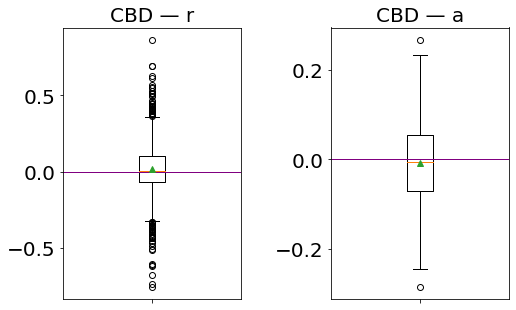

HE


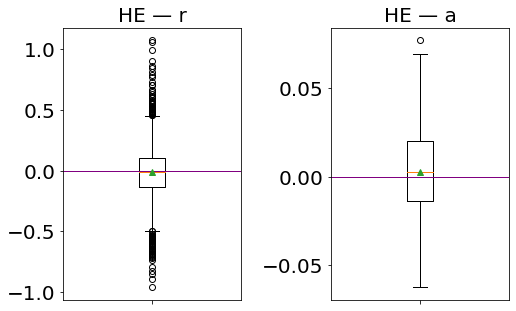

ME


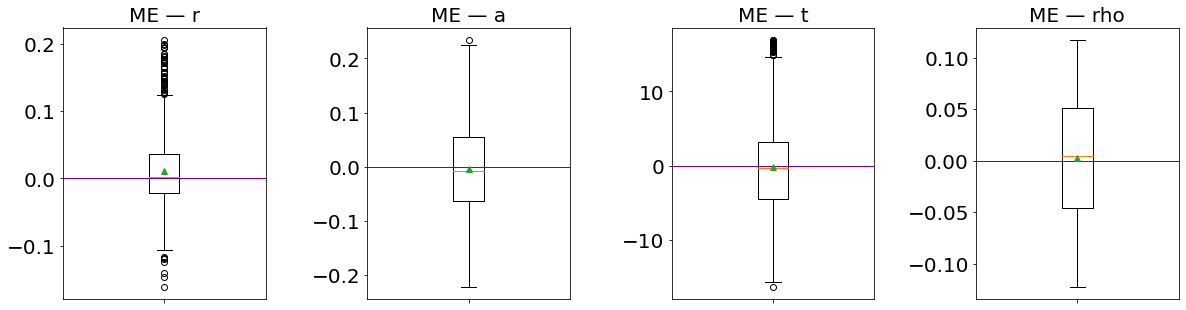

SAT


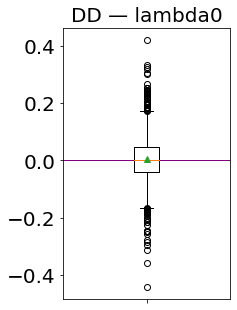

SR


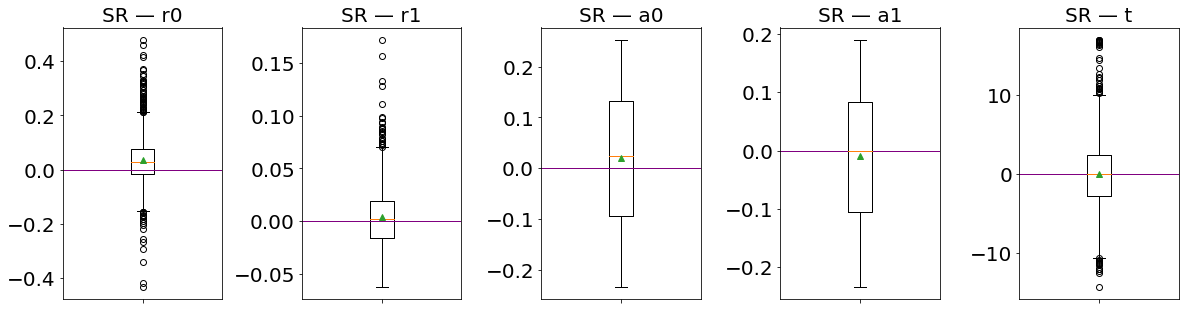

WW


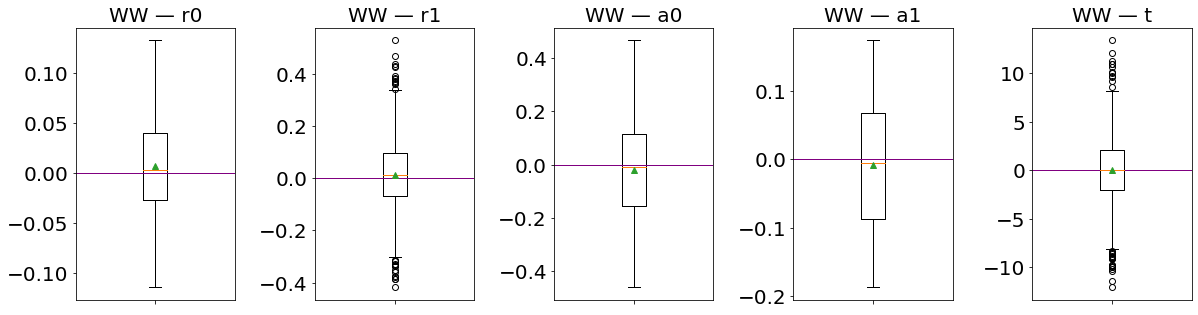

---------489---------
BD


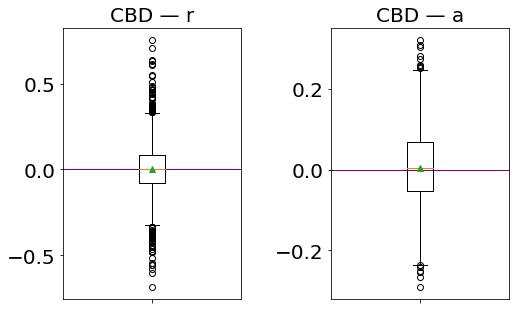

HE


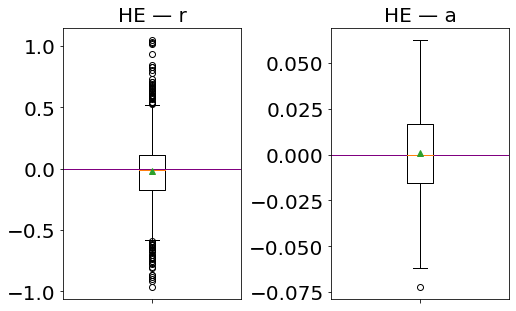

ME


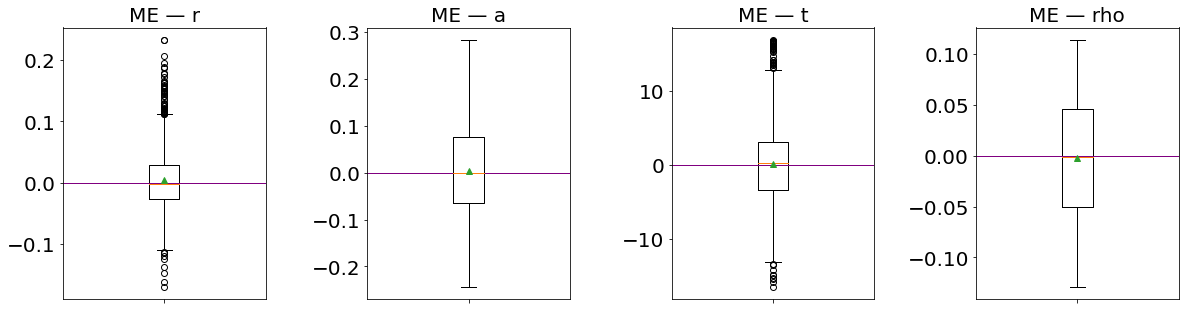

SAT


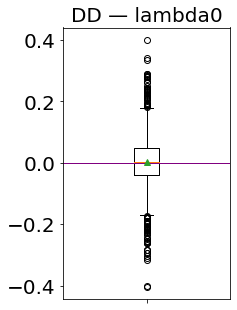

SR


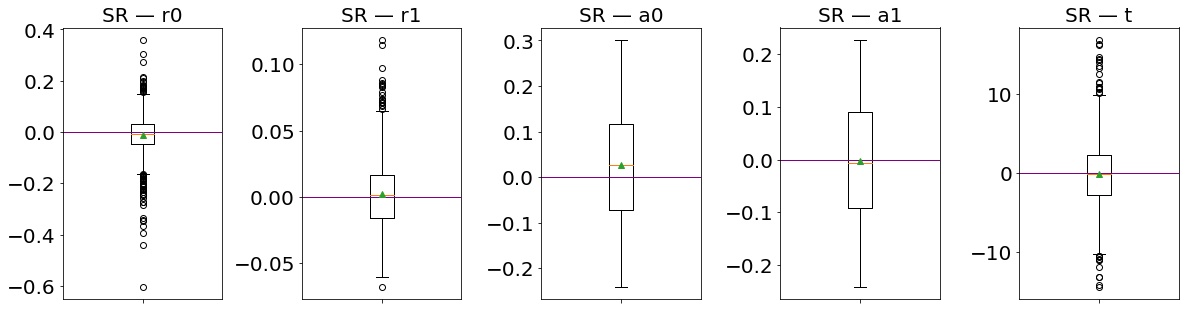

WW


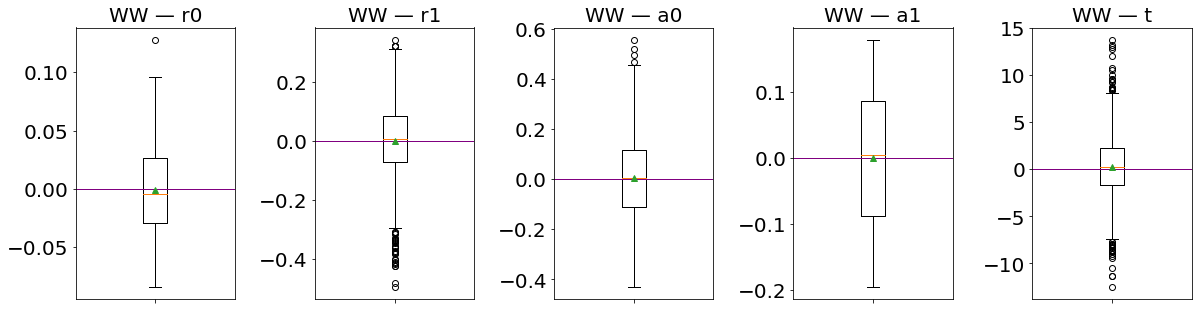

---------87---------
BD


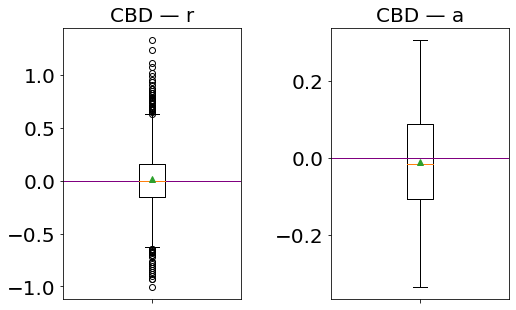

HE


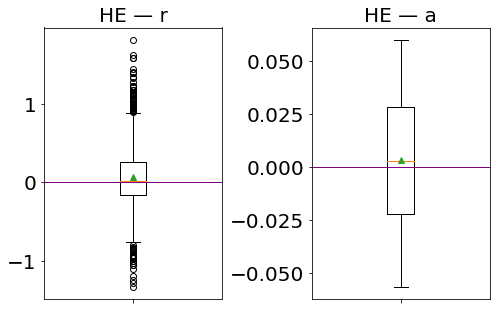

ME


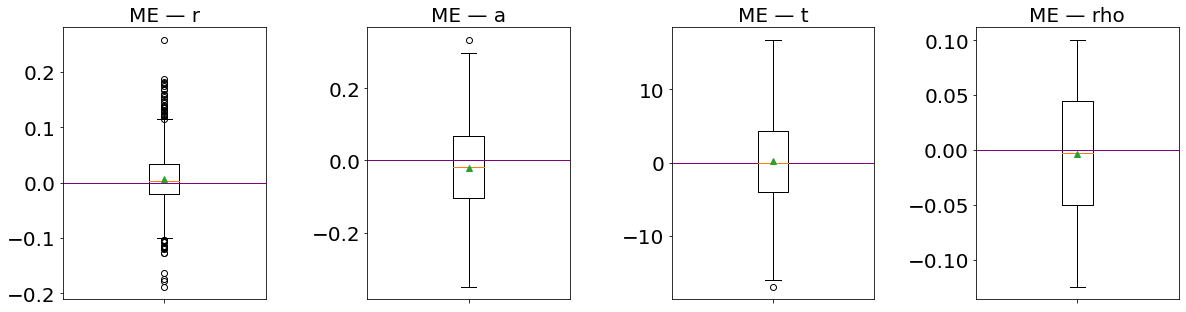

SAT


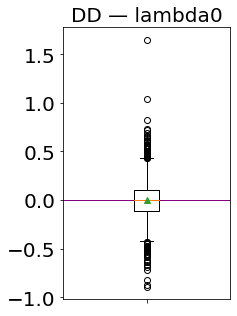

SR


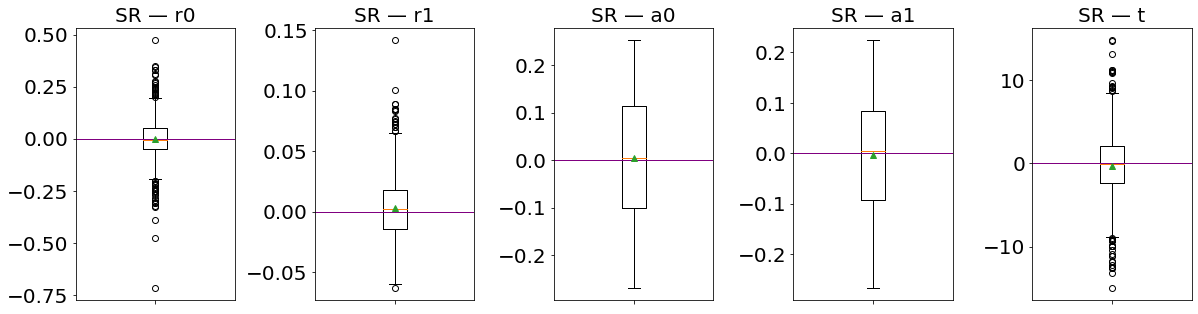

WW


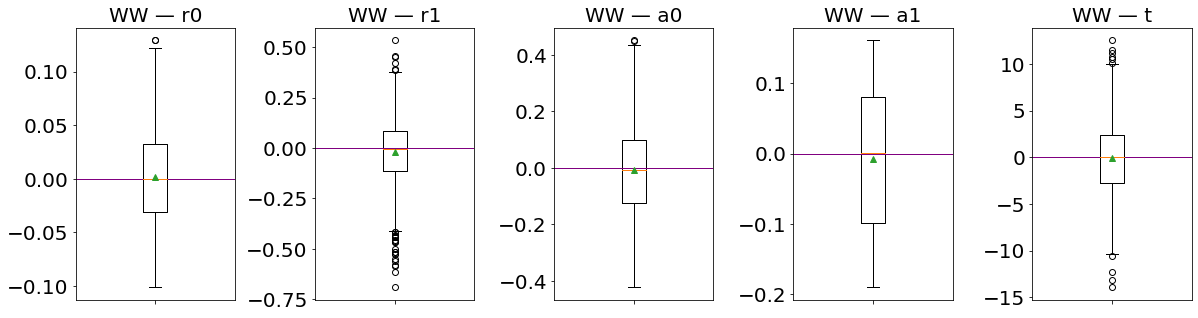

In [21]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        print(scenario)
        plot_errors_boxplot(results, tip, scenario)

### Errors swarmplots 

---------674---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


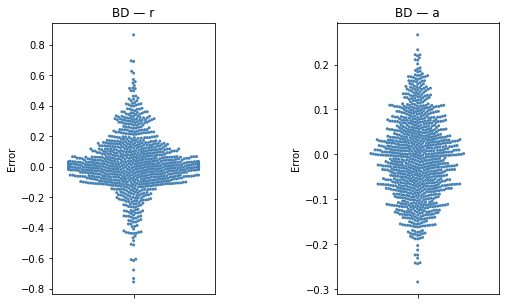

HE


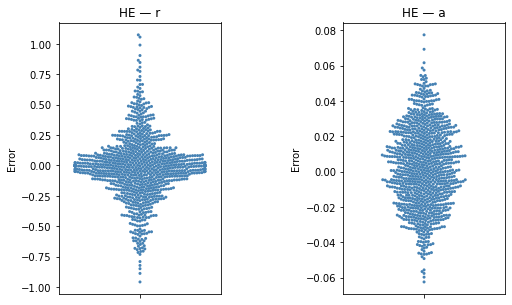

ME


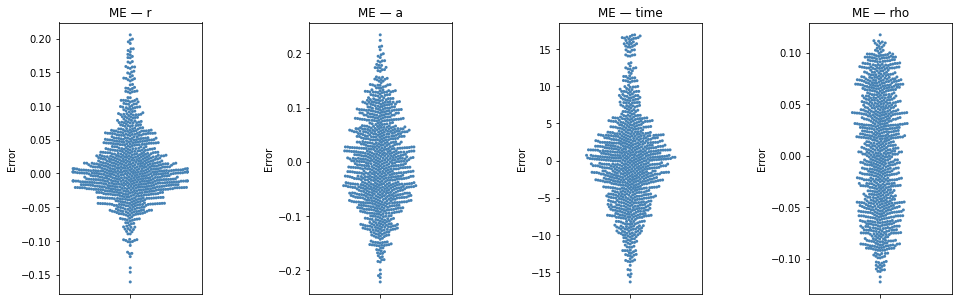

SAT


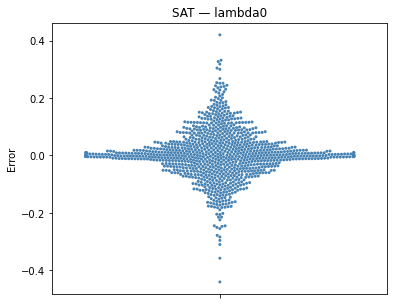

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


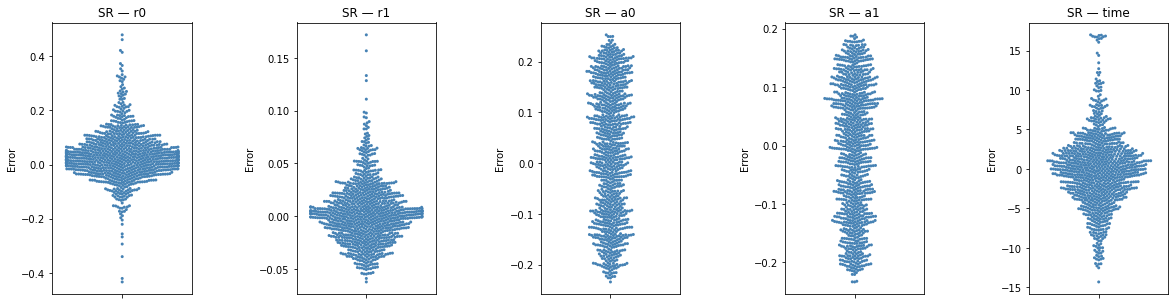

WW


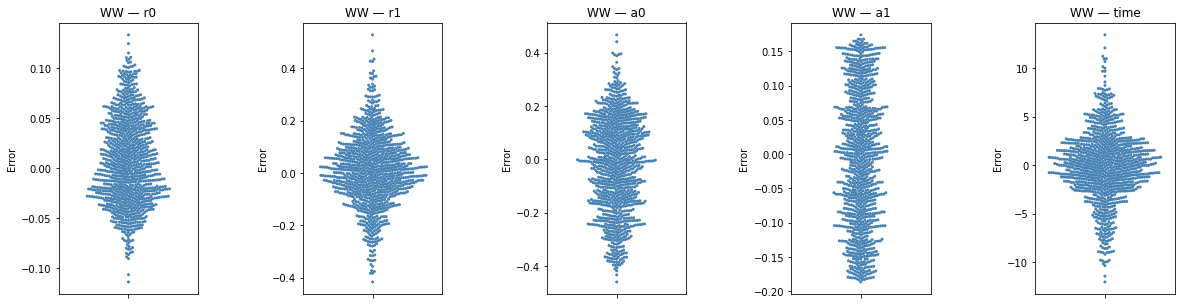

---------489---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


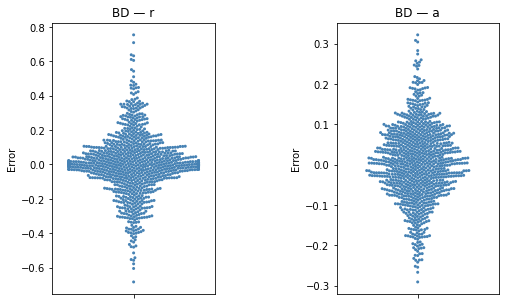

HE


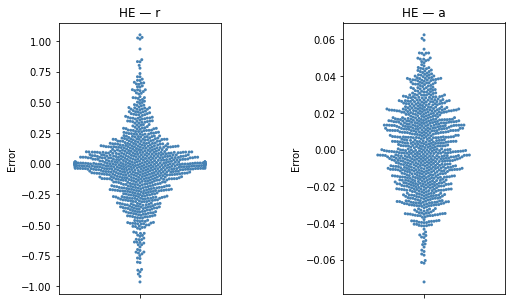

ME


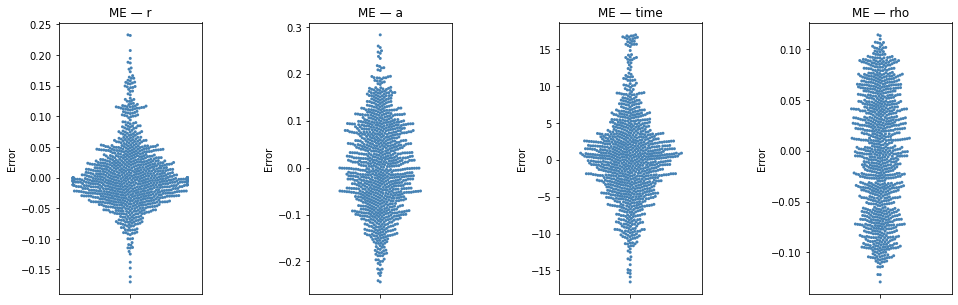

SAT


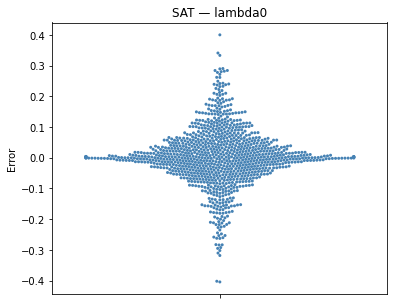

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


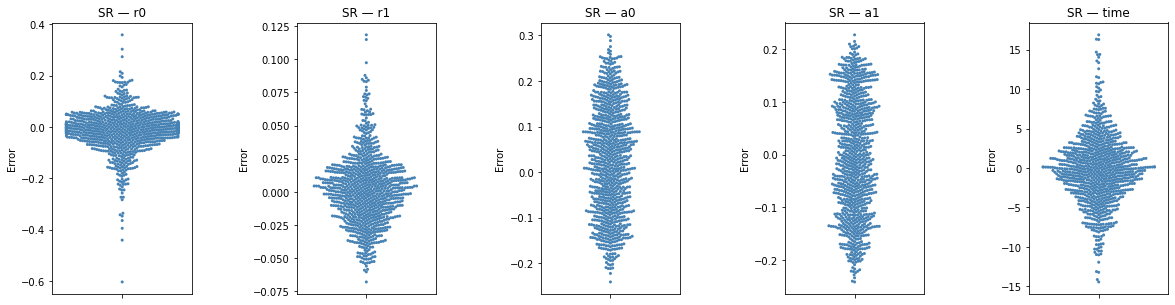

WW


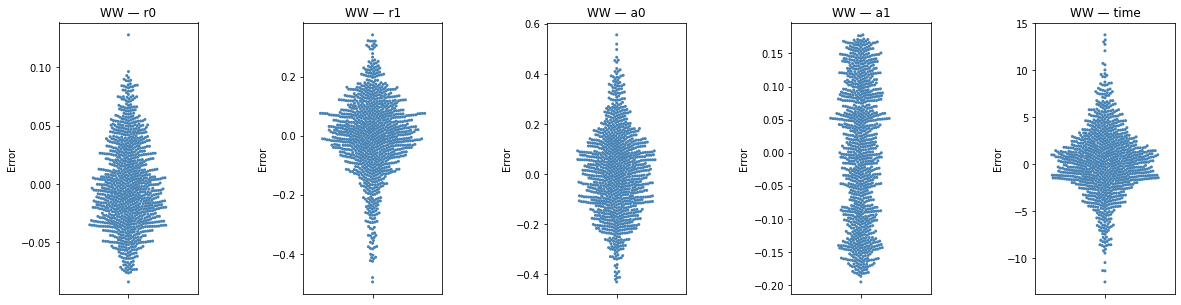

---------87---------
BD


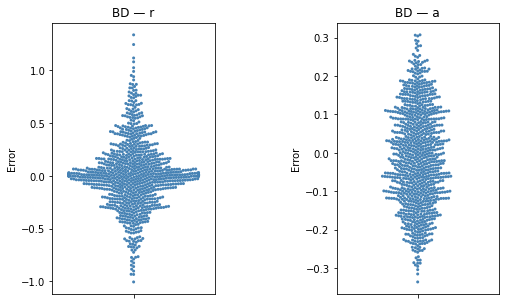

HE


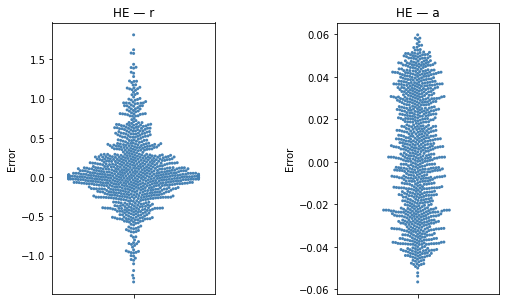

ME


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


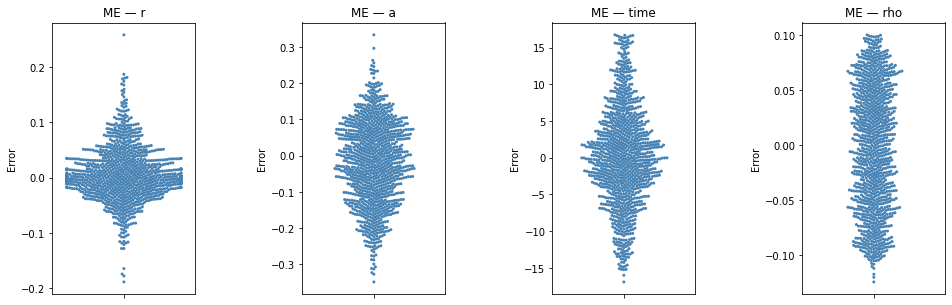

SAT


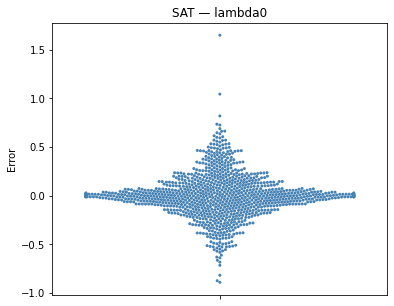

SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


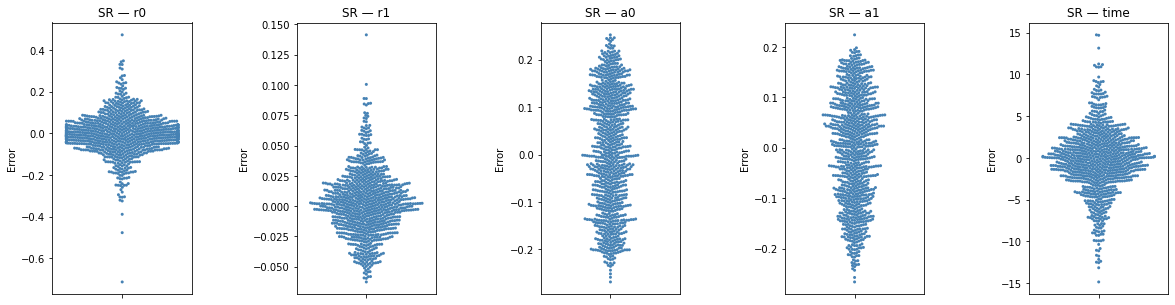

WW


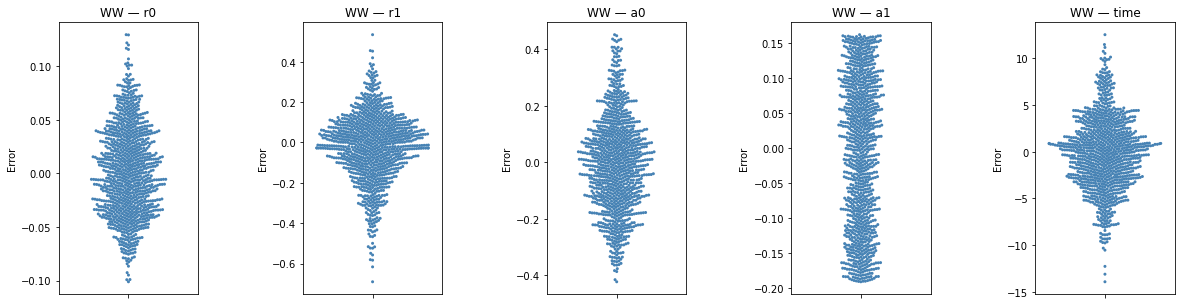

In [14]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        print(scenario)
        plot_errors(results, tip, scenario)

### Absolute errors vs target

---------674---------


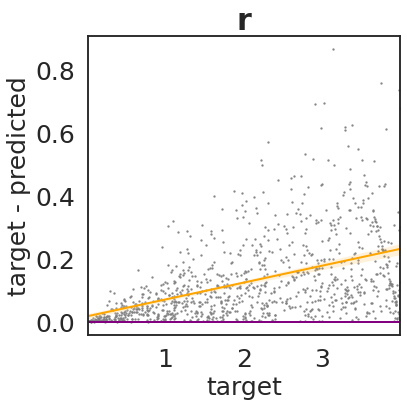

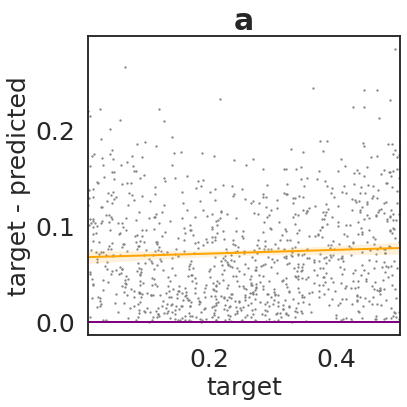

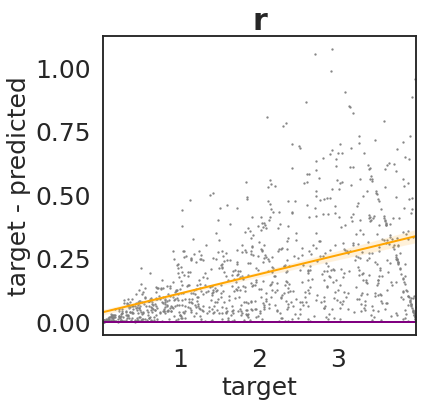

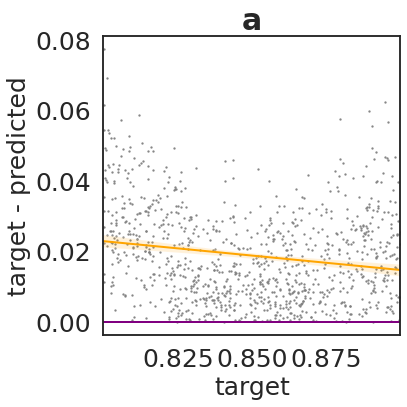

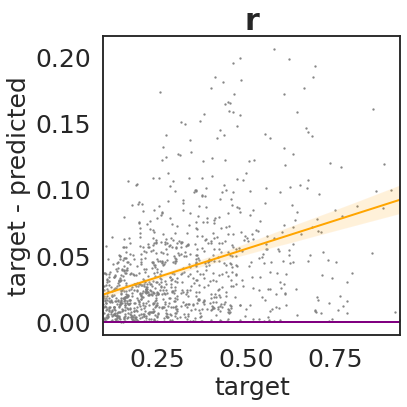

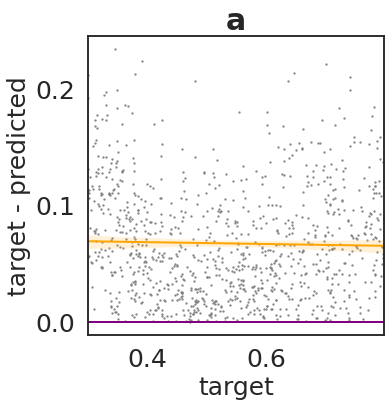

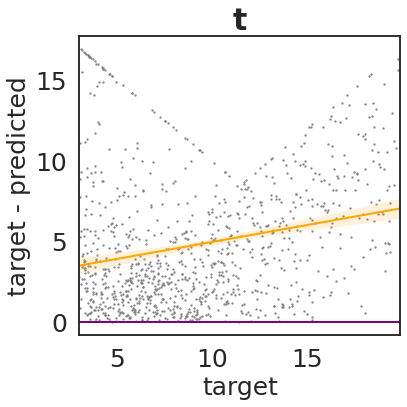

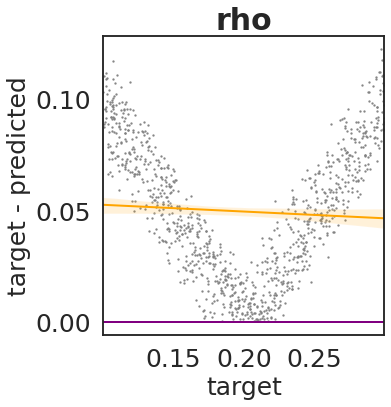

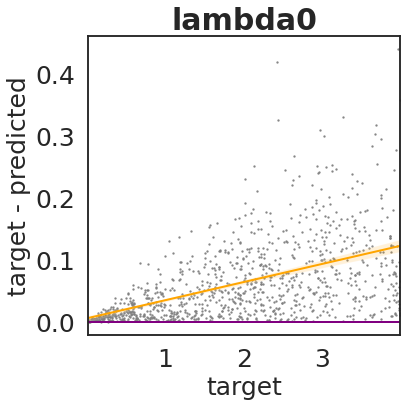

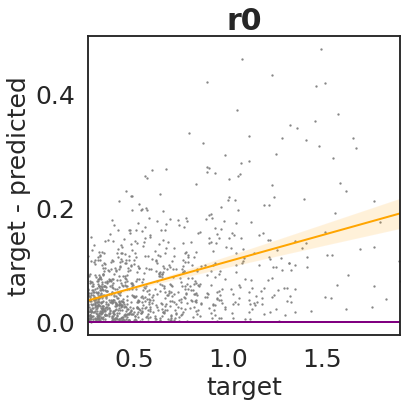

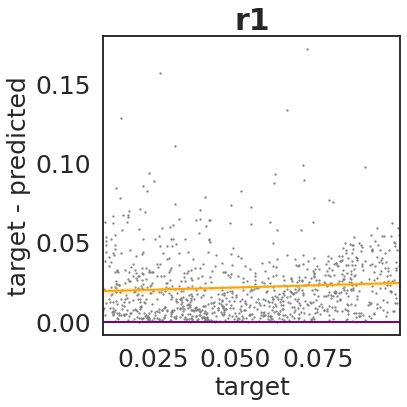

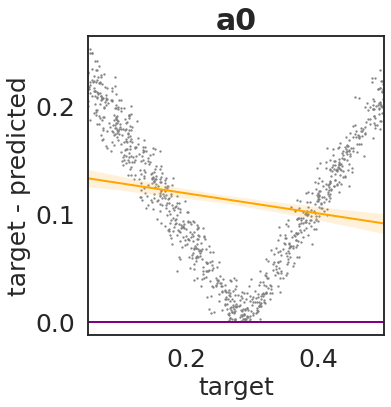

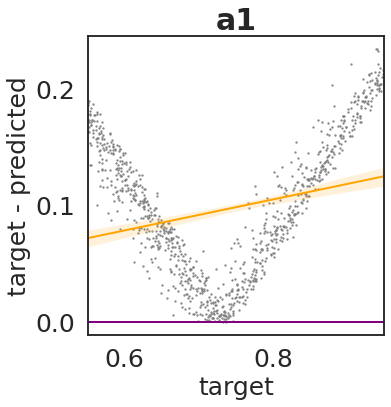

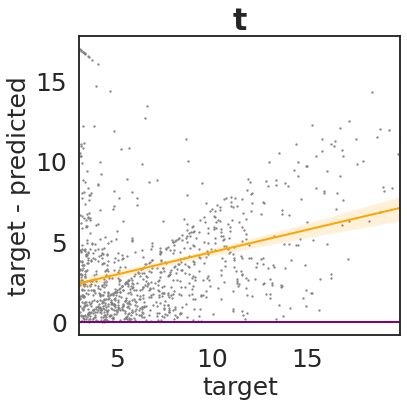

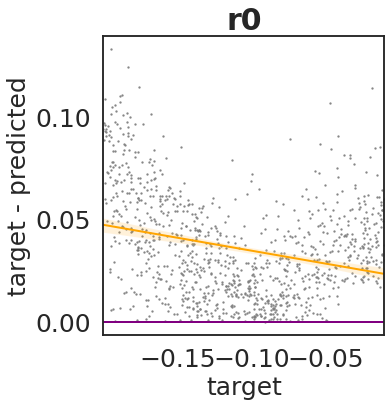

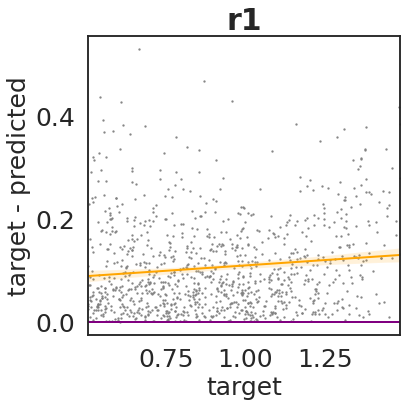

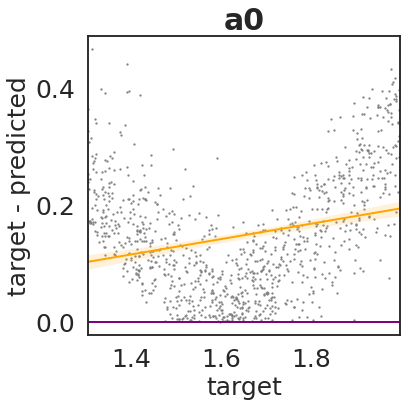

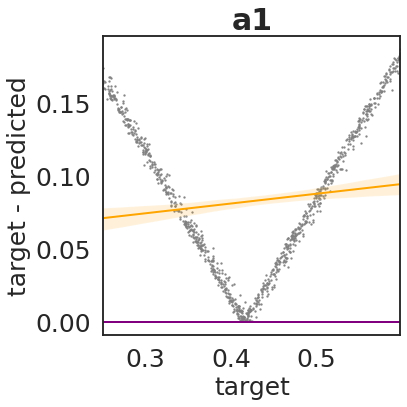

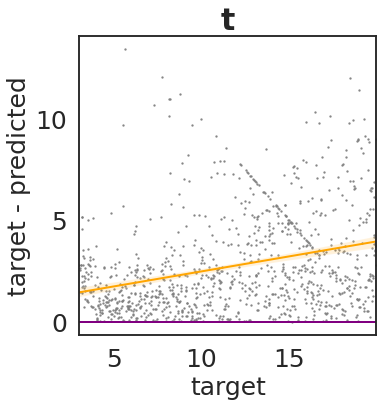

---------489---------


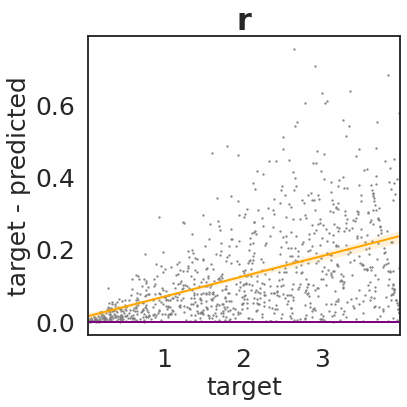

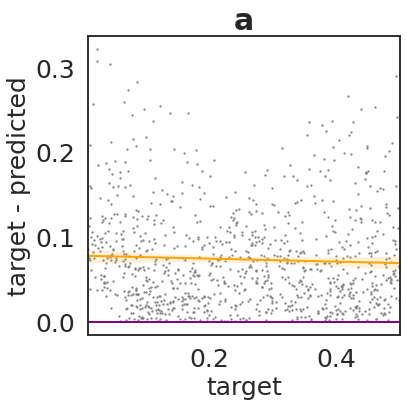

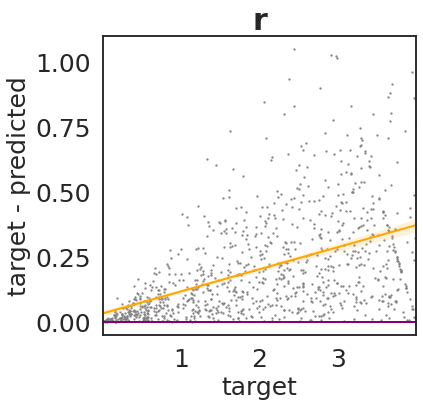

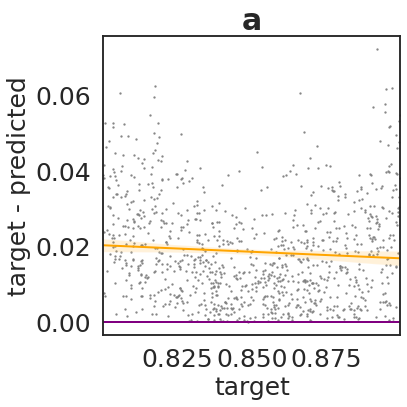

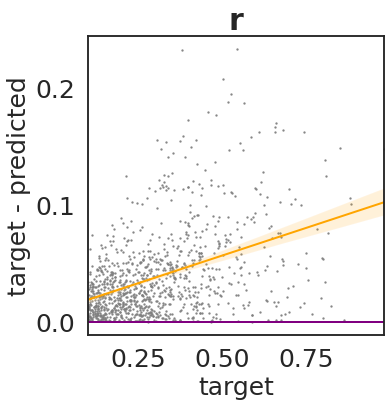

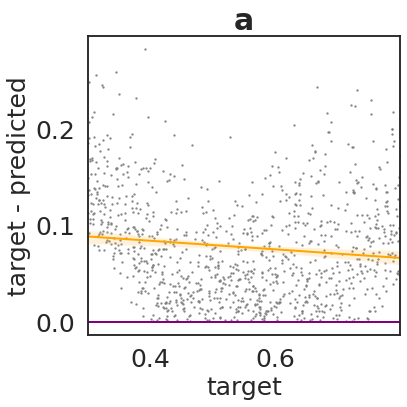

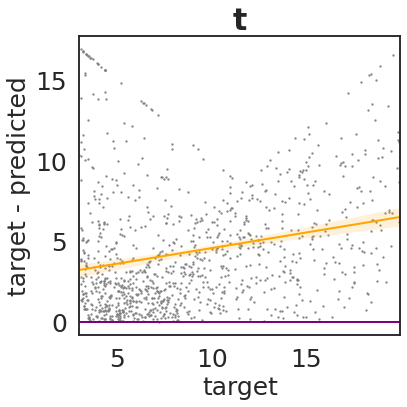

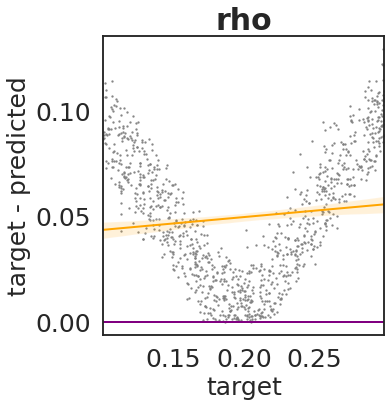

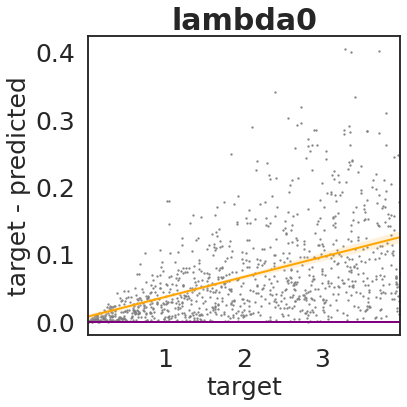

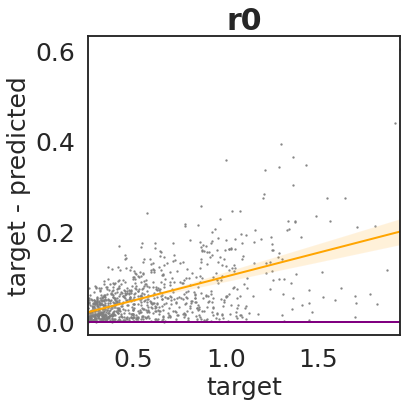

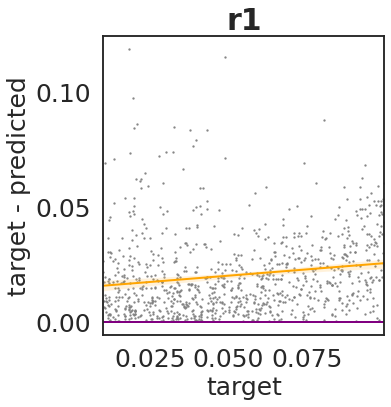

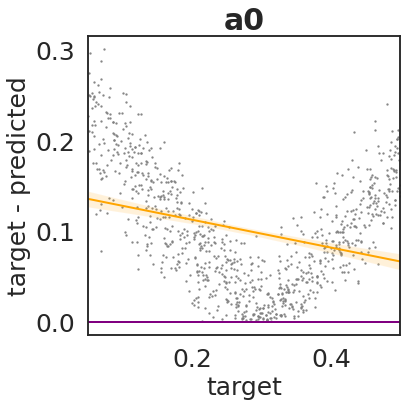

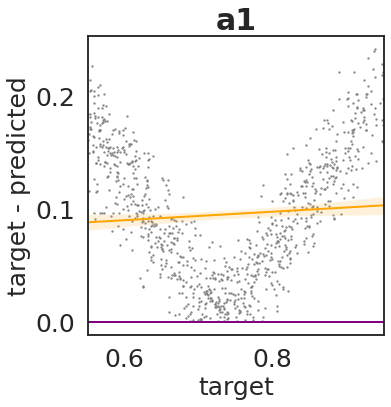

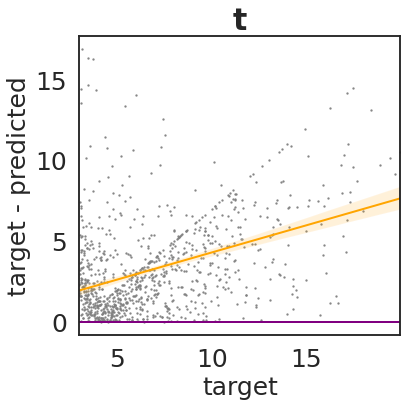

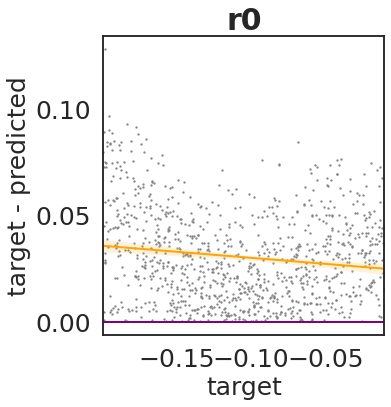

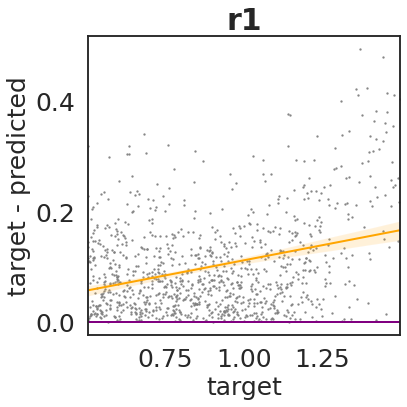

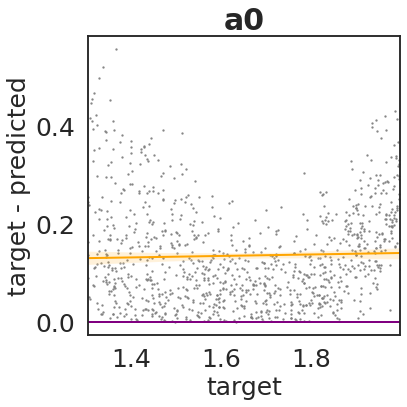

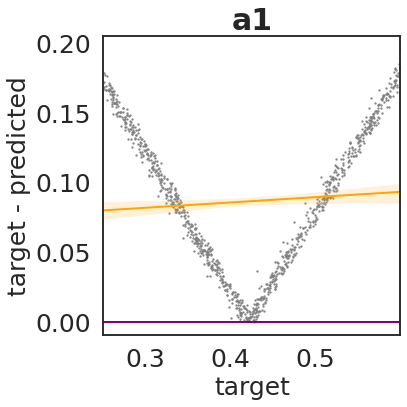

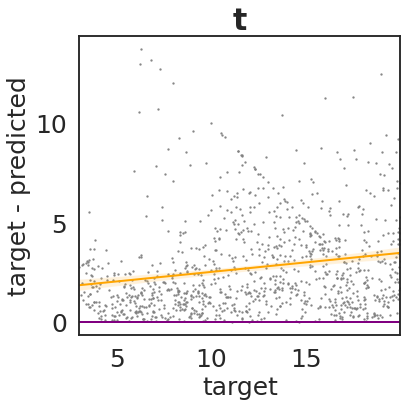

---------87---------


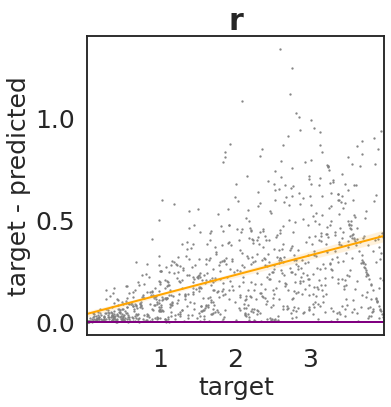

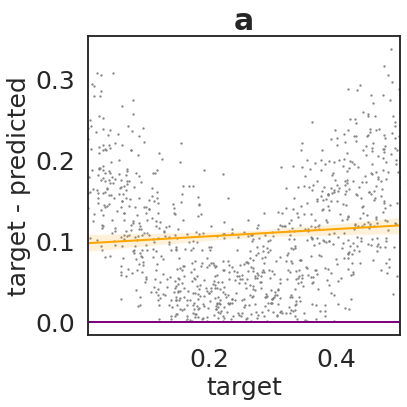

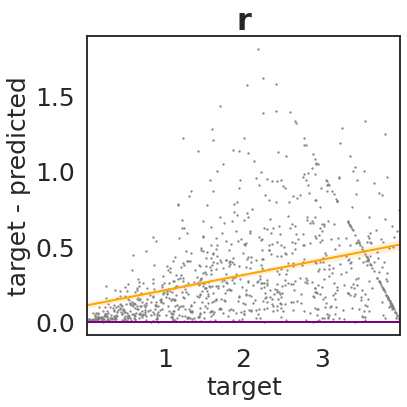

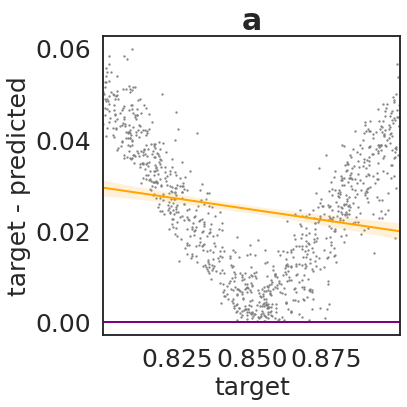

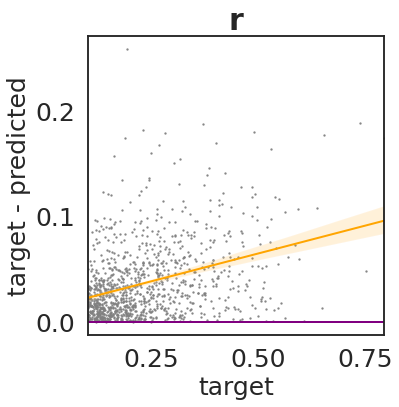

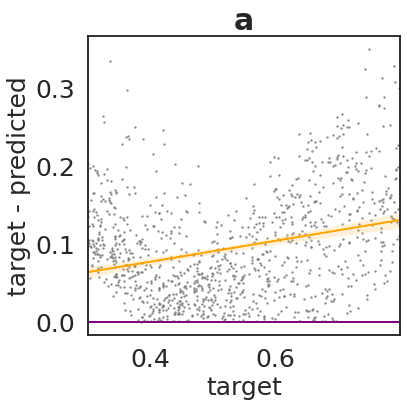

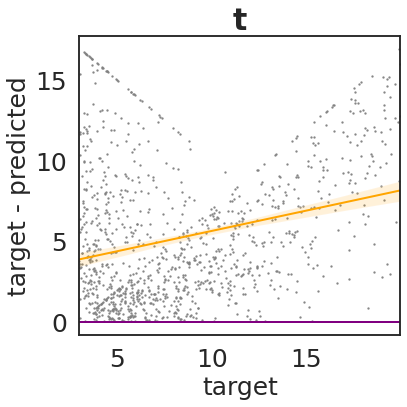

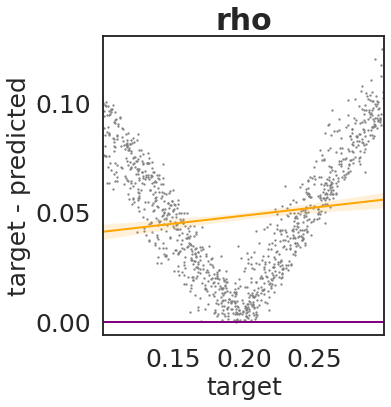

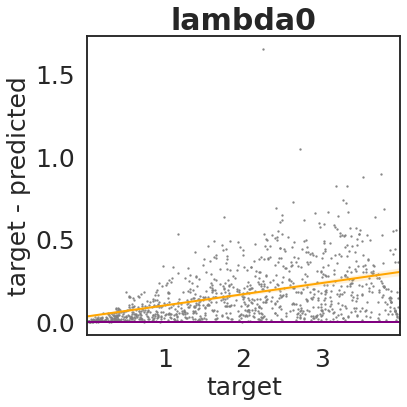

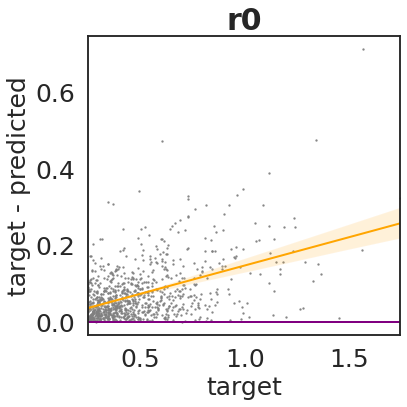

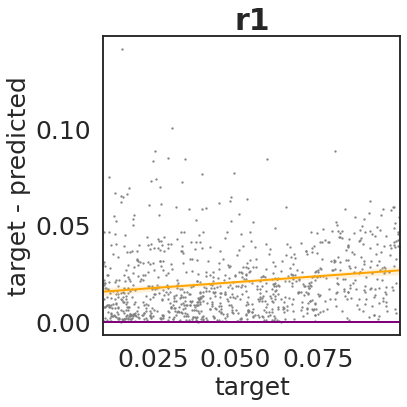

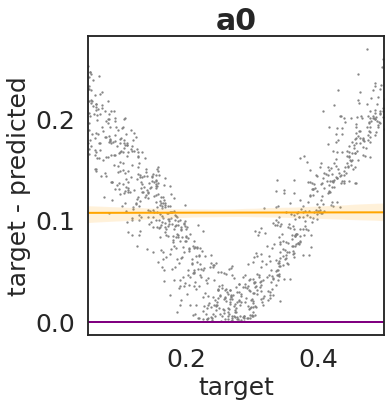

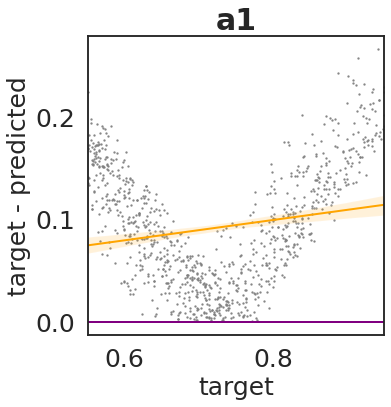

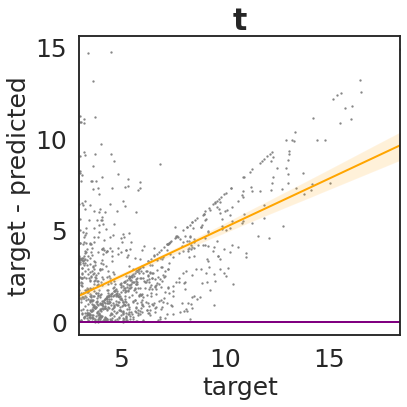

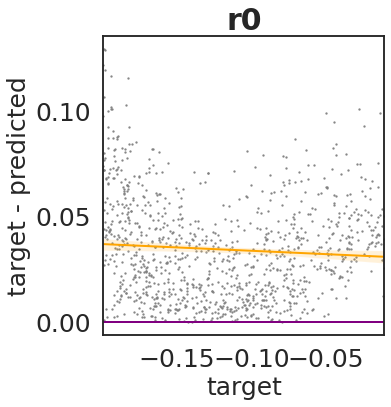

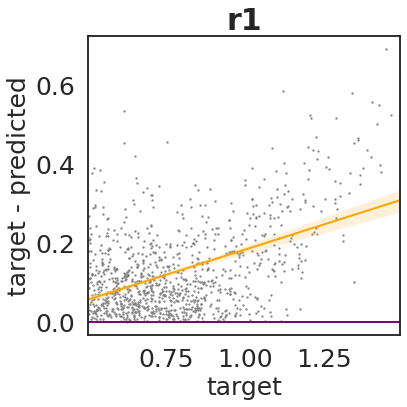

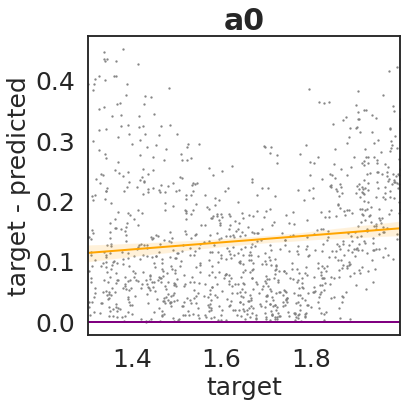

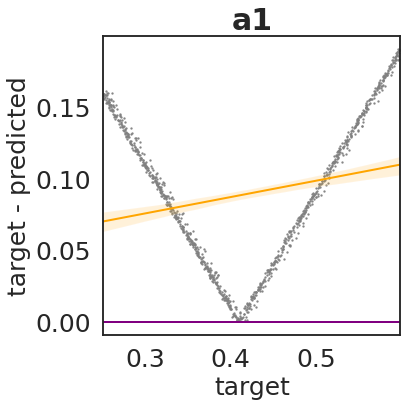

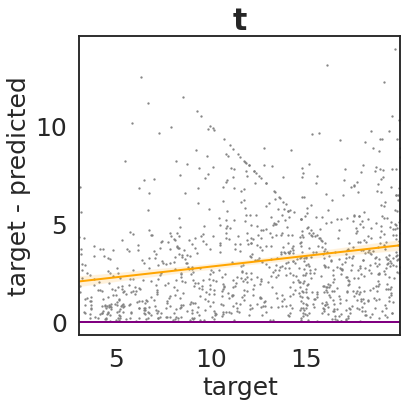

In [17]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        predicted_minus_target_vs_target(results, tip, scenario)